In [1]:
"""Let's try to timestep match"""

"Let's try to timestep match"

In [2]:
"""Imports"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import uproot
import pandas as pd
import re

In [3]:
"""Define functions"""

def baseline_subtract(trace):
    baseline = np.mean(trace[-100:])
    trace = trace.astype(float)
    trace -= baseline
    return trace

def delay_correct(trace, boardID):
    if (boardID<1) or (boardID>4):
        print("Bad BoardID")
        return False
    elif boardID!=1:
        return trace[24*(4-boardID):-24*(boardID-1)]
    else:
        return trace[24*3:]
    
def integrate_ROI_whole(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace)*factor*2/50

def integrate_ROI_majority(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace[160:230])*factor*2/50

def integrate_ROI_alpha(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace[320:390])*factor*2/50

def integrate_ROI_tp(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.sum(trace[380:450])*factor*2/50

def integrate_ROI_v1740(trace):
    factor = 2000/(2**12 - 1)
    #return -1*np.sum(trace[340:370])*factor*2/50
    #return -1*np.sum(trace[350:450])*factor*2/50
    return -1*np.sum(trace)*factor*2/50

def get_calib(filename):
    df = pd.read_csv(filename)
    if len(df) != 58:
        print('Not all channels in calibration file!')
        #return None
    return df.set_index('ch_name')['spe_mean'].to_dict()

def get_height(trace):
    factor = 2000/(2**14 - 1)
    #return -1*np.min(trace[150:250])*factor
    return -1*np.min(trace[210:280])*factor

def get_height_alpha(trace):
    factor = 2000/(2**14 - 1)
    return -1*np.min(trace[90:120])*factor

def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit(data, bins=100, range=(-10, 1000), window_size=10):
    # Step 1: Generate the histogram (frequency counts and bin edges)
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    
    # Step 2: Calculate bin centers (midpoints of each bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Step 3: Identify the peak bin (where counts are maximum)
    peak_index = np.argmax(counts)
    median = np.median(data)
    #peak_index = np.argmin(np.abs(bin_centers - median))
    peak_center = bin_centers[peak_index]
    
    # Step 4: Define the region around the peak to fit
    # Use a window size around the peak (e.g., 5 bins to the left and right)
    start_index = max(0, peak_index - window_size)
    end_index = min(len(bin_centers), peak_index + window_size)
    
    # Step 5: Fit the Gaussian to the selected region
    # Use the selected bin centers and counts around the peak
    selected_bin_centers = bin_centers[start_index:end_index]
    selected_counts = counts[start_index:end_index]
    
    # Initial guess for the parameters: mean (mu), standard deviation (sigma), and amplitude
    initial_guess = [peak_center, np.std(data), max(selected_counts)]
    
    # Fit the Gaussian to the selected region
    popt, _ = opt.curve_fit(gaussian, selected_bin_centers, selected_counts, p0=initial_guess, maxfev=10000)

    # Extract the parameters of the fitted Gaussian
    mu, sigma, amplitude = popt
    '''
    #Step 6: Plotting the histogram and the fitted Gaussian curve
    plt.hist(data, bins=bins, range=range, histtype='step', color='g', label='Histogram')
    
    # Generate a smooth range of x values for plotting the Gaussian
    plt.plot(selected_bin_centers, gaussian(selected_bin_centers, mu, sigma, amplitude), color='r', label='Fitted Gaussian')
    
    # Add labels and legend to the plot
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Show the plot
    plt.show()
    '''
    # Return histogram data and fitted Gaussian parameters (mu, sigma, amplitude)
    return mu, sigma, amplitude

def get_pe(traces, majority_ev, spe_means, event_ttt):
    tot_pe = np.zeros(len(traces['adc_b1_ch1']))
    side_pe = np.zeros(len(traces['adc_b1_ch1']))
    bot_pe = np.zeros(len(traces['adc_b1_ch1']))
    row1_pe = np.zeros(len(traces['adc_b1_ch1']))
    row2_pe = np.zeros(len(traces['adc_b1_ch1']))
    row3_pe = np.zeros(len(traces['adc_b1_ch1']))
    row4_pe = np.zeros(len(traces['adc_b1_ch1']))
    row5_pe = np.zeros(len(traces['adc_b1_ch1']))
    row6_pe = np.zeros(len(traces['adc_b1_ch1']))
    row7_pe = np.zeros(len(traces['adc_b1_ch1']))
    times = np.zeros(len(traces['adc_b1_ch1']))

    bad_chs = ['adc_b1_ch0', 'adc_b2_ch15', 'adc_b4_ch15', 'adc_b4_ch12', 'adc_b4_ch13', 'adc_b4_ch14', 'adc_b3_ch3', 'adc_b3_ch7']
    pattern1 = r'b(\d+)_ch(\d+)'
    pattern2 = r'b(\d+)_p(\d+)'
    for key in traces.keys():
        boardID = re.search(pattern1, key).group(1)
        boardID = int(boardID)
        if (boardID>4) or (key in bad_chs):
            continue
        chkey = chmap[key]
        for ev, trace in enumerate(traces[key]):
            if ev in majority_ev:
                if chkey=='bt_p1':
                    times[ev] += event_ttt[ev]*8e-9
                trace_sub = baseline_subtract(trace)
                trace_good = delay_correct(trace_sub, boardID)
                pulse = integrate_ROI_majority(trace_good)
                pulse_pe = pulse/spe_means[key]
                tot_pe[ev] += pulse_pe
                if ('bt' in chkey):
                    bot_pe[ev] += pulse_pe
                else:
                    side_pe[ev] += pulse_pe
                    column = re.search(pattern2, chkey).group(1)
                    row = re.search(pattern2, chkey).group(2)
                    column = int(column)
                    row = int(row)
                    if column<5:
                        if row==1:
                            row1_pe[ev] += pulse_pe
                        elif row==2:
                            row2_pe[ev] += pulse_pe
                        elif row==3:
                            row3_pe[ev] += pulse_pe
                        else:
                            row4_pe[ev] += pulse_pe
                    else:
                        if row==1:
                            row5_pe[ev] += pulse_pe
                        elif row==2:
                            row6_pe[ev] += pulse_pe
                        else:
                            row7_pe[ev] += pulse_pe
                      
    pes = {}
    pes['bottom'] = bot_pe
    pes['total'] = tot_pe
    pes['side'] = side_pe
    pes['row1'] = row1_pe
    pes['row2'] = row2_pe
    pes['row3'] = row3_pe 
    pes['row4'] = row4_pe
    pes['row5'] = row5_pe
    pes['row6'] = row6_pe
    pes['row7'] = row7_pe
    pes['times'] = times
    return pes

def get_majority(traces):
    trigtag_tpch = 'adc_b5_ch33'
    trigtag_alphach = 'adc_b5_ch34'
    trigtag_majoritych = 'adc_b5_ch35'
    trigtags = [trigtag_tpch, trigtag_alphach, trigtag_majoritych]

    tp_ev = []
    alpha_ev = []
    majority_ev = []

    for key in traces.keys():
        if key in trigtags:
            for ev, trace in enumerate(traces[key]):
                if np.min(trace) < 3000:
                    if key==trigtag_tpch:
                        tp_ev.append(ev)
                    elif key==trigtag_alphach:
                        alpha_ev.append(ev)
                    else:
                        majority_ev.append(ev)

    majority_ev = [ev for ev in majority_ev if ev not in tp_ev]
    alpha_ev = [ev for ev in alpha_ev if (ev not in tp_ev) and (ev not in majority_ev)]
    
    return majority_ev

def get_traces(fname):
    f = uproot.open(fname)
    daq = f['daq']
    traces = {}
    for key in daq.keys():
        if 'adc' in key:
            traces[key] = daq[key].array(library='np')
    event_ttt1 = daq['event_ttt_1'].array(library='np')
    event_ttt2 = daq['event_ttt_2'].array(library='np')
    event_ttt3 = daq['event_ttt_3'].array(library='np')
    event_ttt4 = daq['event_ttt_4'].array(library='np')
    event_id = daq['event_id'].array(library='np')
    #event_ttt = daq['event_ttt'].array(library='np')
    
    return traces, event_ttt1.astype(np.int64), event_ttt2.astype(np.int64), event_ttt3.astype(np.int64), event_ttt4.astype(np.int64), event_id

def get_1t_traces(fname):
    f = uproot.open(fname)
    daq = f['daq']
    # print("printing f.keys() gives:", f.keys())
    # run_info = f['run_info']
    # print(daq.keys())
    traces = {}
    for key in daq.keys():
        if 'adc' in key:
            traces[key] = daq[key].array(library='np') # makes dictionary with channels as keys and values as the data
    event_ttt1 = daq['event_ttt_1'].array(library='np')
    event_ttt2 = daq['event_ttt_2'].array(library='np')
    event_ttt3 = daq['event_ttt_3'].array(library='np')
    event_ttt4 = daq['event_ttt_4'].array(library='np')
    event_ttt5 = daq['event_ttt_5'].array(library='np')
    event_id = daq['event_id'].array(library='np')
    event_sanity = daq['event_sanity'].array(library='np')
    #event_ttt = daq['event_ttt'].array(library='np')
    
    return traces, event_ttt1.astype(np.int64), event_ttt2.astype(np.int64), event_ttt3.astype(np.int64), event_ttt4.astype(np.int64), event_ttt5.astype(np.int64), event_id, event_sanity

In [4]:
"""Source the file with absolute path"""
# abolsute path of interest: /media/disk_a/WbLS-DATA/raw_root/phase6/muon

#fname = '/media/disk_i/30t-DATA/raw_root/phase0/majority_test_250318T1047_75.root'
#fname = '/home/baldoni/drop/test/majority_test_250208T1252_1.root'
#fname = '/home/baldoni/drop/test/majority_test_250310T1145_70.root'
#fname = '/home/baldoni/drop/test/majority_test_250318T1047_75.root'

# Adam's working test
# fname = '/home/baldoni/drop/test/majority_test_250320T1525_57.root'
# traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_id = get_traces(fname)

# my turn
# file convention, year:month:day:T:hour:minute_subrun
# where each subrun has 10K events
fname = "/media/disk_a/WbLS-DATA/raw_root/phase6/muon/muon_wbls05_250105T0911_58.root"
file_traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, file_event_ids, file_event_sanity = get_1t_traces(fname)

In [5]:
# this seems to demonstrate daisy chaining to me
# keep in mind this is in units of trigger ticks, so 1 tick is 6ns
# giving us a 48ns delay for each board


diff21 = event_ttt2 - event_ttt1
diff31 = event_ttt3 - event_ttt1
diff41 = event_ttt4 - event_ttt1
diff51 = event_ttt5 - event_ttt1
print(diff21[:10])
print(diff31[:10])
print(diff41[:10])
print(diff51[:10])

[6 6 6 6 6 6 6 6 6 6]
[12 12 12 12 12 12 12 12 12 12]
[18 18 18 18 18 18 18 18 18 18]
[ -5319456  -7700436  -5217754 -24847724  -2184788  -6954436  -6897140
  -5133714  -3895082 -16666792]


dict_keys(['adc_b5_ch22', 'adc_b2_ch15', 'adc_b2_ch1', 'adc_b3_ch3', 'adc_b2_ch5', 'adc_b5_ch1', 'adc_b5_ch12', 'adc_b3_ch8', 'adc_b5_ch33', 'adc_b5_ch20', 'adc_b4_ch5', 'adc_b3_ch13', 'adc_b2_ch0', 'adc_b5_ch2', 'adc_b5_ch7', 'adc_b5_ch35', 'adc_b5_ch29', 'adc_b4_ch3', 'adc_b5_ch6', 'adc_b3_ch15', 'adc_b4_ch12', 'adc_b2_ch9', 'adc_b3_ch9', 'adc_b5_ch10', 'adc_b5_ch34', 'adc_b5_ch39', 'adc_b5_ch21', 'adc_b3_ch2', 'adc_b4_ch0', 'adc_b5_ch37', 'adc_b4_ch8', 'adc_b4_ch4', 'adc_b1_ch5', 'adc_b5_ch28', 'adc_b2_ch12', 'adc_b3_ch6', 'adc_b2_ch3', 'adc_b4_ch15', 'adc_b5_ch3', 'adc_b1_ch3', 'adc_b2_ch11', 'adc_b3_ch12', 'adc_b1_ch0', 'adc_b3_ch14', 'adc_b5_ch11', 'adc_b5_ch27', 'adc_b2_ch8', 'adc_b3_ch1', 'adc_b5_ch13', 'adc_b5_ch30', 'adc_b1_ch7', 'adc_b2_ch7', 'adc_b1_ch1', 'adc_b4_ch14', 'adc_b5_ch31', 'adc_b4_ch13', 'adc_b4_ch2', 'adc_b1_ch13', 'adc_b5_ch9', 'adc_b4_ch10', 'adc_b5_ch18', 'adc_b5_ch32', 'adc_b3_ch7', 'adc_b1_ch15', 'adc_b1_ch2', 'adc_b2_ch13', 'adc_b5_ch8', 'adc_b4_ch9', 'ad

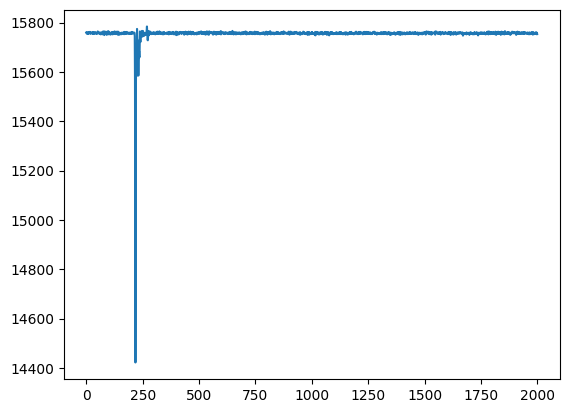

In [6]:
# we can see here all the boards and their corresponding channels and such
# we also plot this random little event, so cute

print(file_traces.keys())
plt.plot(file_traces['adc_b4_ch2'][644])

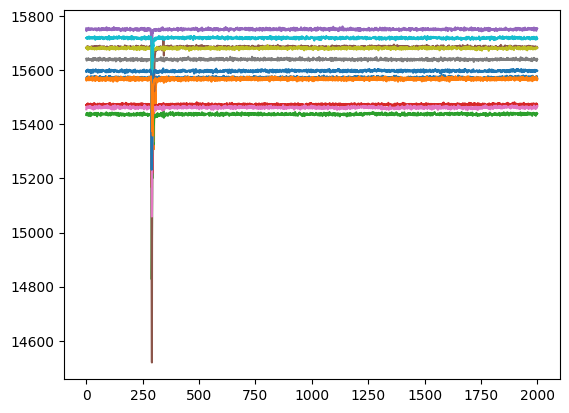

In [7]:
# cheeky code written by Adam to plot multiple channels from same board
for i in range(12):
    ch = 'adc_b1_ch'+str(i)
    plt.plot(file_traces[ch][644], label=ch)
plt.show()

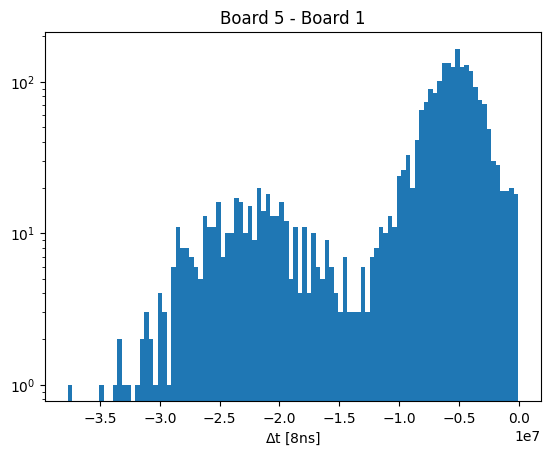

In [8]:
# later after board 5 becomes misaligned, you see something like this?
plt.hist(diff51, bins=100)
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
plt.show()

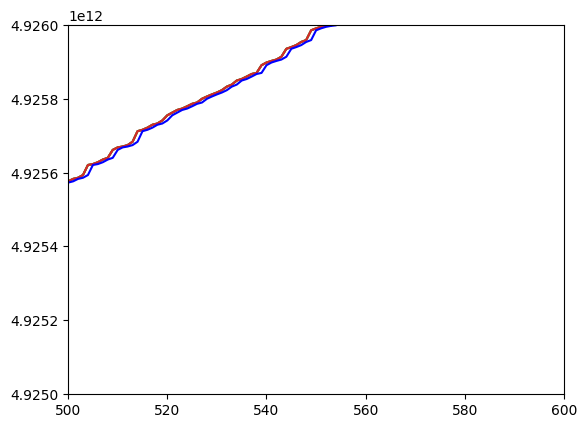

In [9]:
# not particularly elucidating plot
plt.plot(event_ttt1)
plt.plot(event_ttt2)
plt.plot(event_ttt3)
plt.plot(event_ttt4)
plt.plot(event_ttt5, "blue")
plt.xlim(500,600)
plt.ylim(4.925e12,4.926e12)
plt.show()

In [10]:
print([1,2,3][:-1])

[1, 2]


2392


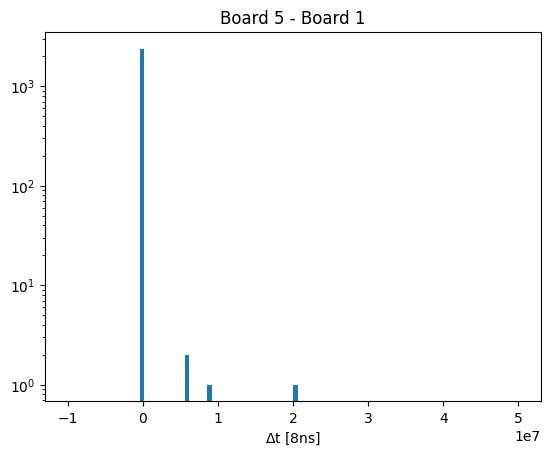

In [11]:
diffs_test = event_ttt5[1:] - event_ttt1[:-1]
print(len(diffs_test))
#plt.hist(diffs_test, bins=100, range=(-17, -13))
plt.hist(diffs_test, bins=100, range=(-1e7, 5e7))
#plt.hist(diff51, bins=100)
plt.yscale('log')
plt.title('Board 5 - Board 1')
plt.xlabel(r'$\Delta$t [8ns]')
#plt.xlim(-20, 20)
#plt.hlines(5e3, -100, 100, 'r')
plt.show()
#print(len([diff for diff in diffs_test if -17<diff and diff<-13])/len(diffs_test))

In [12]:
array_idx = sorted(range(len(file_event_ids)), key=lambda i: file_event_ids[i])
print(array_idx)
print(len(file_event_ids), len(array_idx), len(event_ttt1))
hello = event_ttt1[array_idx]
print(event_ttt1[array_idx])
print(event_ttt1 == hello)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [13]:
print(len(event_ttt1))
print(len(event_ttt2))
print(len(event_ttt3))
print(len(event_ttt4))
print(len(event_ttt5))
print(event_ttt5)

2393
2393
2393
2393
2393
[4921460072339 4921465391779 4921473092201 ... 4941835589583 4941840582949
 4941848051225]


In [14]:
"""New functions for a corrected file"""
# what makes this more correct? hopefully i found out here

def get_1t_info(fname):
    f = uproot.open(fname)
    daq = f['daq']
    daqkeys = daq.keys()
    traces = {}
    for key in daq.keys():
        if 'adc' in key:
            traces[key] = daq[key].array(library='np')
    event_ttt1 = daq['event_ttt_1'].array(library='np')
    event_ttt2 = daq['event_ttt_2'].array(library='np')
    event_ttt3 = daq['event_ttt_3'].array(library='np')
    event_ttt4 = daq['event_ttt_4'].array(library='np')
    event_ttt5 = daq['event_ttt_5'].array(library='np')
    event_id = daq['event_id'].array(library='np')
    event_sanity = daq['event_sanity'].array(library='np')
    #event_ttt = daq['event_ttt'].array(library='np')
    
    return traces, event_ttt1.astype(np.int64), event_ttt2.astype(np.int64), event_ttt3.astype(np.int64), event_ttt4.astype(np.int64), event_ttt5.astype(np.int64), event_id, event_sanity, daqkeys

def correct_times(event_ttt1, event_ttt5, event_id):
    array_idx = sorted(range(len(event_id)), key=lambda i: event_id[i])
    
    event_ttt5_good = event_ttt5[array_idx]
    event_ttt1_good = event_ttt1[array_idx]
    
    event_ttt5_good_idx = []
    event_ttt1_good_idx = []
    
    window_size = 3
    
    for i, val1 in enumerate(event_ttt1_good):
        # Define the search window (max 3 elements before and after in event_ttt5_good)
        start_idx = max(i - window_size, 0)
        end_idx = min(i + window_size + 1, len(event_ttt5_good))

        # Find the index of the closest element in event_ttt5_good within the window
        local_window = event_ttt5_good[start_idx:end_idx]
        closest_idx = np.argmin(np.abs(local_window - val1)) + start_idx  # Add start_idx to get global index

        if -17 < (event_ttt5_good[closest_idx ] - val1) < -13:
            event_ttt1_good_idx.append(i)
            event_ttt5_good_idx.append(closest_idx)
            
    event_ttt1_good_final = np.array(array_idx)[event_ttt1_good_idx]
    event_ttt5_good_final = np.array(array_idx)[event_ttt5_good_idx]
    
    return event_ttt1_good_final, event_ttt5_good_final

def write_corrected_root(outfname, traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, event_id, event_sanity, daqkeys, run_info, event_ttt1_good_final, event_ttt5_good_final):
    
    new_daq = {}
    for key in daqkeys:
        if "adc_b5" in key:
            new_daq[key] = traces[key][event_ttt5_good_final]
        elif "adc" in key:
            new_daq[key] = traces[key][event_ttt1_good_final]
    new_daq["event_ttt5"] = event_ttt5[event_ttt5_good_final]
    new_daq["event_ttt4"] = event_ttt4[event_ttt1_good_final]
    new_daq["event_ttt3"] = event_ttt3[event_ttt1_good_final]
    new_daq["event_ttt2"] = event_ttt2[event_ttt1_good_final]
    new_daq["event_ttt1"] = event_ttt1[event_ttt1_good_final]
    new_daq["event_id"] = event_id[event_ttt1_good_final]
    new_daq["event_sanity"] = event_sanity[event_ttt1_good_final]

    output_file = uproot.recreate("corrected_file.root")
    output_file['daq'] = {branch: new_daq[branch] for branch in new_daq}

    data = run_info.arrays(library='np')
    output_file['run_info'] = {branch: data[branch] for branch in data}
    output_file.close()

In [20]:
fname = '/media/disk_k/WbLS-DATA/raw_root/phase9/muon/muon_wbls1pct_250311T1511_12.root'
traces, event_ttt1, event_ttt2, event_ttt3, event_ttt4, event_ttt5, event_id, event_sanity, daqkeys = get_1t_info(fname)
array1_final, array2_final = correct_times(event_ttt1, event_ttt5, event_id)
print(array1_final)
print(array2_final)
print(len(array1_final), len(array2_final))

[  36   37   38 ... 9839 9840 9841]
[  36   37   38 ... 9840 9841 9842]
9730 9730


In [11]:
copy_this = []
for i in range(12):
    copy_this.append("adc_b4_ch" + str(i))
print(len(copy_this), copy_this)

12 ['adc_b4_ch0', 'adc_b4_ch1', 'adc_b4_ch2', 'adc_b4_ch3', 'adc_b4_ch4', 'adc_b4_ch5', 'adc_b4_ch6', 'adc_b4_ch7', 'adc_b4_ch8', 'adc_b4_ch9', 'adc_b4_ch10', 'adc_b4_ch11']


30 16 12
adc_b3_ch0
0


IndexError: list index out of range

In [2]:
corrected_file_name = "/media/disk_o/my_corrected_roots/corrected_" + "hello" + ".root"
print(str(corrected_file_name))

/media/disk_o/my_corrected_roots/corrected_hello.root


[1, 2, 3, 4, 5, 6, 7, 8]
